# <div style="text-align: center;" markdown="1">Discrete Item Response Theory framework</div> 

# <div style="text-align: center;" markdown="1">for implementing a placement test </div>
***

![alt text](http://static.kremlin.ru/media/events/photos/big/46lbUrou7zra5VJjQ5TSN20O3IAslTbj.jpeg)

# Summary

### [0. Some functions inherited from continuous IRT framework](#section 0)
## Using non parametric IRT method in order to compute p($U_{i}$|$\theta$) more effectively
> ### [I. Calibrating the item pool](#section 1)
> ### [II. Some useful functions to manipulate capsules](#section 2)
> ### [III. The placement test](#section 3)

# Global Imports

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import statsmodels.api as sm
import pandas as pd
from scipy.optimize import minimize_scalar
from sklearn.linear_model import LogisticRegression
from scipy.stats import rv_continuous, norm, truncnorm, beta
from scipy.integrate import quad
from numba import jit

from igraph import Graph
from igraph.drawing import plot as igraph_plot
from matplotlib.collections import LineCollection
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.utils import check_random_state

# Creating the Graph

In [3]:
def create_map_graph(edges_list,N=None):
    map_graph = Graph(edges_list, directed=True)
    map_graph.vs["label"] = map_graph.vs["name"] = [str(i+1) for i, v in enumerate(map_graph.vs)]
    if N is not None:
        map_graph.vs["item pool"] = [["q_"+str(i+1)+"_"+str(j+1) for j in range(N[i])] for i, v in enumerate(map_graph.vs)]
    return map_graph

def plot_map_graph(map_graph):
    layout = map_graph.layout_sugiyama()
    return igraph_plot(map_graph, bbox=(400, 400), layout=layout)

In [4]:
#Example
edges_list = [
    (0, 1),
    (0, 2),
    (2, 3),
    (1, 3)
]
N = [7, 6, 5, 7] 

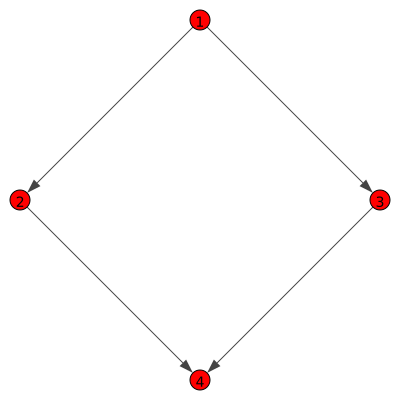

In [5]:
map_graph = create_map_graph(edges_list,N)
plot_map_graph(map_graph)

<a id="section 0"></a>

# 0. Some functions inherited from continuous IRT framework

In the IRT model, the probability $P$ that a student with ability $\theta$ answers a question correctly is given by:
$$P(\theta) = c + \frac{1-c}{1 + \exp (-a \cdot (\theta - b))}$$
where $a$ is the \emph{discrimination} parameter of the question, $b$ is its \emph{difficulty} and $c$ is the probability of answering it correctly by chance (for instance, $1/n$ if it is a single-answer MCQ with $n$ propositions). We will also compare this framework with with the normal ogive model :
$$P(\theta) = c + (1-c)\Phi(a \cdot (\theta - b))$$
Where $\Phi$ is the Cumulative Distribution Function (CDF) of a standard normal distribution.

The underlying model is that a student who does not answer by chance will answer correctly if the latent variable
$$U^\ast = a \cdot (\theta - b) + \epsilon$$
is greater than 0, where $\epsilon$ is an unobserved error term that follows a logistic distribution.

The variable that denotes whether the answer was answer correctly, $U$, will be equal to one iff a uniform RV draw gives a value greater than $c$ or if $U^\ast > 0$.

We start be defining helper functions that describe the model.

In [6]:
def irt_latent_variable(a, b, theta, mode="3pl", eps_variance=None):
    """
    Generates a latent variable U* indicating the student's propensity of answering correctly
    based on the question's parameters (a and b) and the student's ability (theta).
    The unobserved error term has variance eps_variance.
    """
    if mode.lower() == "3pl":
        scale = 1.0 if eps_variance is None else sqrt(3 * eps_variance) / np.pi
        return a * (theta - b) + np.random.logistic(scale=scale)
    elif mode.lower() == "ogive":
        scale = 1.0 if eps_variance is None else eps_variance
        return a * (theta - b) + np.random.normal(scale=scale)
    else:
        raise ValueError("Unknown mode: %s" % mode)
        

def did_answer_correctly(u_star=None, chance=0.0):
    """
    Computes whether the student gave a correct answer (variable U)
    given the latent variable U star and the probability of answering correctly by chance, c.
    """
    
    if chance > 1.0 or chance < 0.0:
        raise ValueError("chance must be between 0.0 and 1.0.")
    chance_draw = np.random.uniform()
    if chance_draw < chance:
        return True
    else:
        return u_star > 0.0
    
def proba_irt(a, b, c, theta, mode="3pl"):
    """
    Returns the probability of answering correctly a question of parameters a, b and c given ability theta.
    :param a: Question discrimination
    :param b: Question difficulty
    :param c: Probability of answering correctly by chance
    :param theta: Student's ability
    :return: Probability of answering correctly the question (between 0 and 1)
    """
    
    if mode.lower() == "3pl":
        return c + (1. - c) / (1. + exp(-a * (theta - b)))
    elif mode.lower() == "ogive":
        return c + (1. - c) * norm.cdf(a * (theta-b))
    else:
        raise ValueError("Unkwown mode: %s" % mode)

def proba_irt_array(a, b, c, theta, mode="3pl"):
    """
    Compute the probabilities of answering a series of questions with parameters a, b, c.
    :param a: List of questions discrimination parameters
    :param b: List of questions difficulty parameters
    :param c: List of probabilities of answering each question correctly by chance
    :param theta: Student's ability (float)
    :return: Array of probability of answering each question correctly 
    """
    
    probas = []
    for i in range(len(a)):
        probas.append(proba_irt(a[i], b[i], c[i], theta, mode=mode))
    return np.array(probas)

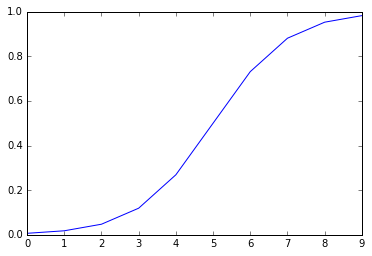

In [7]:
plt.plot(proba_irt(1,5,0,np.arange(10)))

# Using non parametric IRT method in order to compute p($U_{i}$|$\theta$) more effectively
***

This work is mainly based on [Adaptive testing for hierarchical student models,Guzman,Conejo,Prez-de-la-Cruz, 2005](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.473.6734&rep=rep1&type=pdf). In order to simplify drastically our model and improve computation time we will no longer consider a continuous parameter $\theta$ instead we will consider $\theta$ can only take K values : 0,..,K-1 corresponding to the levels of comprehension of a concept (associated with a capsule). We will generate score panels. For $i \in \{0,..,N\}$ First by using a linear framework : $P(u_i = 1|\theta=\theta_a) = \frac{\theta_a}{K}$. And then by using classic IRT: $P(u_i = 1|\theta=\theta_a) = IRT(\theta_a,a_i,b_i,c_i)$

In [8]:
@jit
def generate_score_panel(number_users, number_questions, k):
    """
    Compute a panel of answers by simulated students
    :param number_users: Number of users
    :param number_questions: Number of questions inside the capsule
    :param k: Number of knowledge levels
    :return: Array of answers for each user, scores for each user (percentage of accurate answers) and level generated
    randomly
    """
    level_users = (np.arange(k)[::-1]/float(sum(np.arange(k)))).cumsum().searchsorted(numpy.random.sample(number_users))
    p = np.empty(number_users)
    for index,a in enumerate(level_users):
        p[index] = ((np.arange(k))/float(k))[a] 
    answers = np.empty([number_users, number_questions])
    for index, proba in enumerate(p):
        answers[index] = np.random.binomial(p=proba,n=1,size=number_questions)
    scores = np.mean(answers, axis=1)
    return answers, scores, level_users

In [9]:
def generate_alt_score_panel(number_users, number_questions, k):
    level_users = (np.arange(k)[::-1]/float(sum(np.arange(k)))).cumsum().searchsorted(numpy.random.sample(number_users))
    p = np.where(level_users < (k)/2., 0., 1.)
    answers = np.empty([number_users, number_questions])
    for index, proba in enumerate(p):
        answers[index] = np.random.binomial(p=proba,n=1,size=number_questions)
    scores = np.mean(answers, axis=1)
    return answers, scores, level_users

In [10]:
def generate_irt_score_panel(number_users, number_questions,a,b, k):


# Student abilities
    level_users = np.random.uniform(0,k,size=number_users)

# Student answers
    latent_variables = np.array([irt_latent_variable(a[index], b[index], t) for index,t in enumerate(level_users)])
    answers = np.array([[did_answer_correctly(u_star, 0.0) for u_star in latent_variables]])
    scores = np.mean(answers, axis=1)
    return answers, scores, level_users

In [11]:
#Run this cell for Linear model test
k = 10
number_users = 2000
number_questions = 7
a = np.random.uniform(0,1,size=number_questions)
b = np.random.uniform(0,1,size=number_questions)
h =  .3
answers, scores, level_user = generate_alt_score_panel(number_users, number_questions, k)


In [12]:
#Run this cell for IRT model test
# Real parameters of the question (no chance answer)
a = 1.
b = 5.

# Number of students
Number_students = 10000

# Student abilities
theta = np.random.uniform(0,1,size=Number_students)

# Student answers
latent_variables = np.array([irt_latent_variable(a, b, t) for t in theta])
u = np.array([[did_answer_correctly(u_star, 0.0) for u_star in latent_variables]])
score = theta
score

array([ 0.1292949 ,  0.17729195,  0.41615032, ...,  0.66776001,
        0.21601467,  0.4230114 ])

<a id = "section 1"></a>

## I. Calibrating the Item Pool
***

 We will use a non-parametric approach in order to estimate $p(u_i | \theta)$. This methode described in Ramsay (1991) consists in using prior information about how student who did not undertake placement test answered questions. It comprises several steps (Guzman, Conejo, Pérez-de-la-Cruz 2005):







### I.1 Prior Student session compilation 

We collect information about how student answered question .If we have information on whether he answered the question correctly, we will call the model a dichotomous model and only need one probability distribution per question. If we have information about which proposition a student chose, we can define a probability distribution for each proposition, meaning that if a question has W propositions we will define W-1 probability distributions. First we will only consider dichotomous approach.


### I.2 Score Computation 

For each student his/her score is computed, we will choose the percentage of good answers as a score.

### I.3 Score Transformation 

We will then seek the corresponding quantile in the normal distribution. That will give us a score that will be transposed to discrete via a linear transformation.

In [13]:
#Let's assume that there are k knowledge level, we will apply step 3:
@jit
def normalize_score(scores, k):
    """
    Compute the normalized score : discrete transformation of normal quantiles
    :return: Array of transformed scores
    """
    a = (k-1.)/5.
    b = (k-1.)/2.
    transformed_score = b+truncnorm(-2.5,2.5).ppf(scores)*a
    return transformed_score


### I.4 Smoothing 

In [14]:
# Rajouter une note sur l'espérance conditionnelle

If there were N students who undertook the test, we can approximate $P(U_i = 1| \theta)$ by :

$$\forall k \in [0,K-1], P_i(u_i = 1| \theta = k) = \sum_{a = 1}^{N}{w_{ak}u_{ai}}$$

Where $u_{ai}$ = 1 if student a answered question i correctly. and $w_{ak}$ is calculated as:
$$w_{ak}= \frac{\kappa(\frac{\theta_a-\theta_k}{h})}{\sum_{b=1}^{N}{\kappa(\frac{\theta_b-\theta_k}{h})}}$$
where $\theta_a$ is the knowledge level estimated for student a, $\theta_k$ is the kth knowledge level.

In [15]:
@jit
def generate_weight(scores, k, h, updated_score=None, kernel="gaussian"):
    """
    Compute the weight to calculate the the probability of answering a question correctly knowing one's knowledge level
    :param scores: non-Normalized scores
    :param k: List of questions difficulty parameters
    :param h: Bandwith -> illustrate bias-variance trade-off the less the value of h the more variance but the less bias
    :param updated_score: When we have already estimated student's ability there is no need to discretize it.
    :param kernel: Currently implemented : gaussian kernel, quadratic kernel and uniform kernel
    :return: Array of weights w_ak
    """
    if updated_score is None:
        transformed_score = normalize_score(scores, k)
    else:
        transformed_score = updated_score
    delta_theta = np.empty([k, len(transformed_score)])
    w = np.empty([k, len(scores)])
    for i in range(k):
        delta_theta[i] = transformed_score - i
    if kernel == "gaussian":
        kernel_transform = exp(-(delta_theta/h)**2)/2.
    elif kernel == "quadra":
        kernel_transform = np.where(abs(delta_theta/h)>1,0,1-(delta_theta/h)**2)
    elif kernel == "unif":
        kernel_transform = np.where(abs(delta_theta/h)>1,0,1)
    sum_kernel_transform = np.sum(kernel_transform, axis=1)
    for index,(a,b) in enumerate(zip(kernel_transform, sum_kernel_transform)):
        w[index] = a/b 
    return w

In [16]:
@jit
def calculate_probas_nonparam(w, answers):
    """:return: [P(u_i|theta), theta in (0,K-1)]"""
    n_questions = len(answers.T)
    k = len(w)
    probas_calculated = np.empty([n_questions, k])
    for i in range(n_questions):
        for j in range(k):
            probas_calculated[i][j] = np.dot(w[j], answers.T[i])
    return probas_calculated

### I.5 Student knowledge level inference 

Using recently calibrated model one can use the MAP in order to find student's level k. We can estimate the real ability of users by using :
    $$\forall a \in \{1,..,N\},\forall k \in \{0,..,K-1\}, P(\theta_a=k|u_1,...,u_n)=\prod_{i=1}^{n}{P_i(u_i|\theta_a=k)}.$$
where n is the number of questions. We then use the maximum a posteriori estimator to estimate $\theta$:
$$\forall a \in \{1,..,N\}:k_a=\max_{j \in \{0,..,K-1\}}{P(\theta_a=j|u_1,...,u_n)}, \theta_a = k_a$$

In [17]:
@jit
def find_map(number_users, answers, probas_1,k):
    """:return: k_a MAP level for user a"""
    proba_post = np.empty([number_users,k])
    probas_1t = probas_1.T
    for a in range(number_users):
        n = len(answers[a])
        for level in range(k):
            prod = 1
            mat = np.where(answers[a]==1,probas_1t[level],1-probas_1t[level])
            for i in range(n):
                prod = prod*mat[i]
            proba_post[a][level] = prod
    return np.argmax(proba_post, axis=1)

Then we will use the updated scores found by maximum a posteriori to update our initial estimation, we will do so until probabilities are not fluctuating anymore.

In [18]:
@jit
def find_consistent_probas(score, answer, k, h, eps=.1, kernel="gaussian"):
    """:return:  [P(u_i|theta), theta in (0,K-1)] """
    updated_scores = None
    number_users, number_questions = np.shape(answer)
    probas = np.zeros([number_questions,k])
    w = generate_weight(score, k, h, updated_scores,kernel)
    probas_1 = calculate_probas_nonparam(w, answer)
    current_diff = 1000
    while current_diff > eps:
        updated_scores = find_map(number_users,answer, probas_1, k)
        w = generate_weight(score, k, h, updated_scores,kernel)
        probas = calculate_probas_nonparam(w,answer)
        current_diff = np.mean(abs(probas-probas_1))
        probas_1 = probas
    return probas, updated_scores

The following cell is a test of the model. h is the bandwith of the estimation, the smaller h you chose the smaller the bias but the higher the variance. If we assume that the underlying model is approximately gaussian (that our response function are gaussian) one can use Silverman's Rule. The best way to find h is by using cross validation method. $$h = \min_{\hat{h}}{CV(\hat{h})}$$
Where:
$$CV(h) = \int{\hat{P_h}(x)^2dx}-\frac{2}{n(n-1)}\sum_{i=1}^{n}{\sum_{j\neq i}{K(\frac{\theta_i-\theta_j}{h})}}$$

### I.6 Testing the calibration algorithm

0.0526092380827


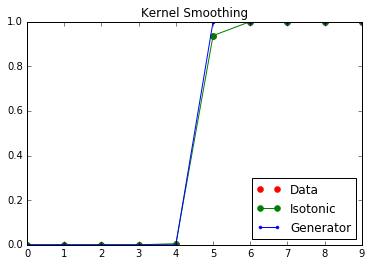

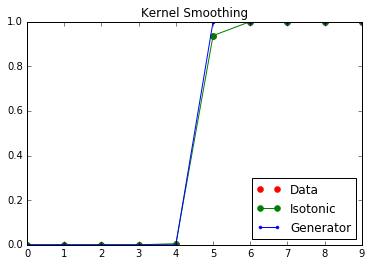

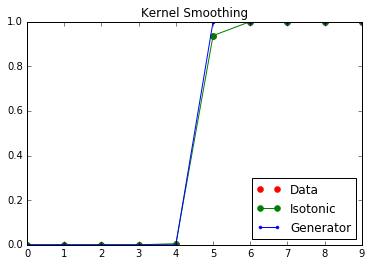

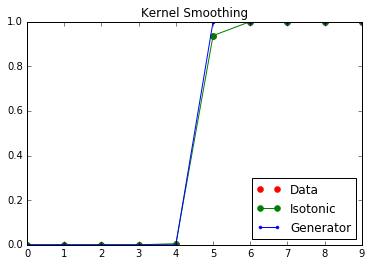

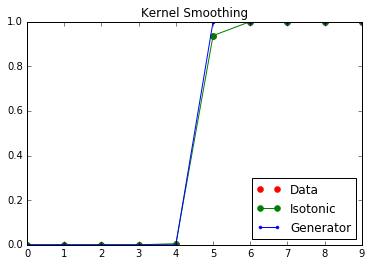

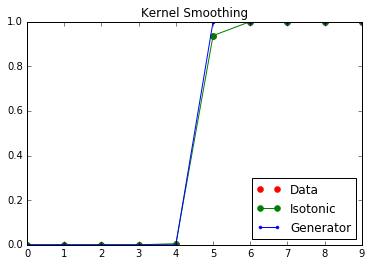

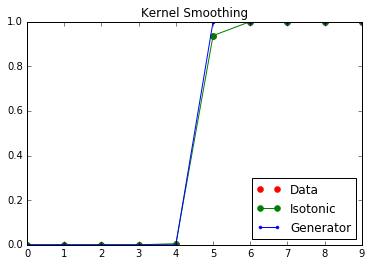

In [19]:
h = 1.5
consistent_probas, updated_scores = find_consistent_probas(scores, answers, k, h)

x = np.zeros((number_questions,k))
y = np.zeros((number_questions,k))
y_ = np.zeros((number_questions,k))
for i in range(number_questions):
    x[i] = np.where(np.arange(k) < 5,0.,1.)
    y[i] = consistent_probas[i]

    # Fit IsotonicRegression in case the estimated probability is not increasing

    ir = IsotonicRegression(increasing=True)

    y_[i] = ir.fit_transform(np.arange(k), y[i])
    
#This is the mean square error which allows us to measure the accuracy of our estimation
mse = 0
for i in range(number_questions):
    mse += (1./len(y_[i]))*np.sum((y_[i]-x[i])**2)
print sqrt(mse)

# We hid everything that concerns Isotonic Regression, we will only need it if some curves are non-increasing
for i in range(number_questions):
    #segments = [[[o, y[i][o]], [o, y_[i][o]]] for o in range(k)]
    #lc = LineCollection(segments, zorder=0)
    #lc.set_array(np.ones(len(y[i])))
    #lc.set_linewidths(0.5 * np.ones(k))

    fig = plt.figure()
    plt.plot(np.arange(k), y[i], 'r.', markersize=12)
    plt.plot(np.arange(k), y_[i], 'g.-', markersize=12)
    plt.plot(np.arange(k), x[i],'b.-')
    #plt.gca().add_collection(lc)
    plt.legend(('Data', 'Isotonic', 'Generator'), loc='lower right')
    plt.title('Kernel Smoothing')

<font color='red'>TO DO : Check if the results are different with isotonic regression </font>. See [On the Use of Nonparametric ICC Estimation Techniques
For Checking Parametric Model Fit, Wollack, Lee, Douglas, 2004 ](https://testing.wisc.edu/research%20papers/AERA%202004%20%28Lee%20&%20Wollack%29.pdf )

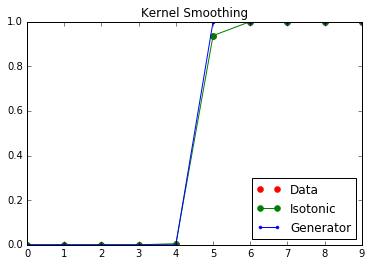

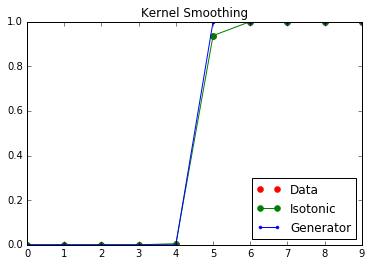

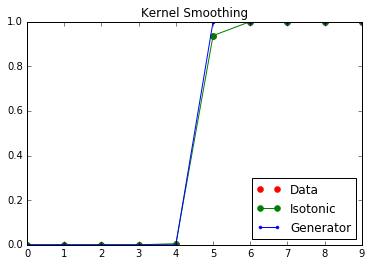

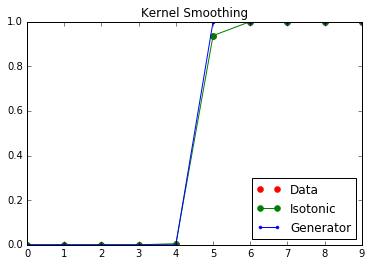

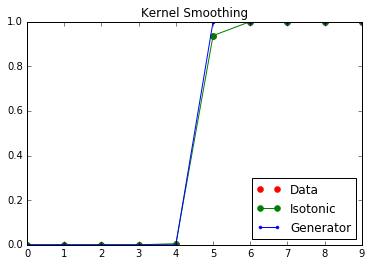

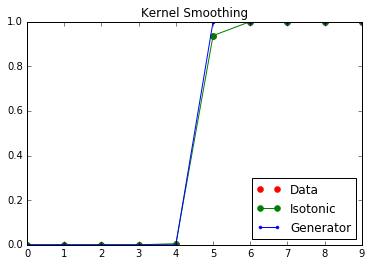

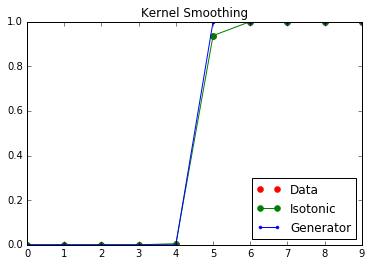

In [20]:
# We hid everything that concerns Isotonic Regression, we will only need it if some curves are non-increasing
for i in range(number_questions):
    #segments = [[[o, y[i][o]], [o, y_[i][o]]] for o in range(k)]
    #lc = LineCollection(segments, zorder=0)
    #lc.set_array(np.ones(len(y[i])))
    #lc.set_linewidths(0.5 * np.ones(k))

    fig = plt.figure()
    plt.plot(np.arange(k), y[i], 'r.', markersize=12)
    plt.plot(np.arange(k), y_[i], 'g.-', markersize=12)
    plt.plot(np.arange(k), x[i],'b.-')
    #plt.gca().add_collection(lc)
    plt.legend(('Data', 'Isotonic', 'Generator'), loc='lower right')
    plt.title('Kernel Smoothing')

### I.7 Using calculated scores to infer prior distribution of $\theta$

Now we will implement an a priori distribution for $P(\theta)$, since we have knowledge on the mean value of theta, we can discretize a normal distribution with mean equal to the mean of theta.

In [21]:
def p_theta(k, knowledge_distribution = None):
    p_theta = np.arange(k)
    if knowledge_distribution is not None:
        mean = np.mean(knowledge_distribution)
        std = np.std(knowledge_distribution)
        custom_norm = norm(loc=mean,scale=1) # We might need to adjust this parameter
        p_theta=custom_norm.cdf(p_theta)
        y = np.zeros(k)
        y[1:] = p_theta[:-1]
        p_theta = p_theta - y
    else:
        p_theta = 1/(k*np.ones(k))
    return p_theta
        

We will initialize our model, 1000 users answered every question, thus allowing us to measure their knowledge level:

In [22]:
k = 10
number_users = 1000
number_questions = N
h = 1.5
answers = []
scores = []
level_users = []
for i in range(len(N)):
    answer, score, level_user = generate_alt_score_panel(number_users, number_questions[i], k)
    answers.append(answer)
    scores.append(score)
    level_users.append(level_user)
    

In [23]:
proba_updaters = []
scores_updated = []
for i in range(len(N)):
    consistent_probas, updated_scores = find_consistent_probas(scores[i], answers[i], k, h)
    proba_updaters.append(consistent_probas)
    scores_updated.append(updated_scores)

In [24]:
p_theta_all = []
for i in range(len(N)):
    p_theta_all.append(p_theta(k,scores_updated[i]))

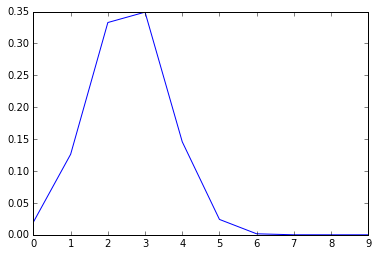

In [25]:
#An example of how our discretized distributions look
plt.plot(p_theta_all[1])

<a id ="section 2"></a>

# II. Some useful functions to manipulate capsules
***

We will now define a few useful function for our model. First the direct inclusion relation. For $C_i,C_j\in\Omega$ where $\Omega$ is the capsule set, $C_i \in \gamma(C_j)$ if there is an arc in the graph between $C_i$ and $C_j$. It corresponds to children of $C_j$.

In [26]:
def gamma_corresp(C):
    return set(map_graph.neighbors(C, mode="ALL"))

Then the inclusion relation. For $C_i,C_j\in\Omega$, $C_i \in \gamma^+(C_j)$ if there is a directed path in the graph between that comes from $C_j$ and goes to $C_i$.

In [27]:
def gamma_plus(C, direction = 'descending'):
    if direction == 'descending':
        nodes = set([C])
        linked_nodes = set(map_graph.neighbors(C,mode="OUT"))
        while len(nodes) > 0:
            for node in nodes:
                nodes = set(map_graph.neighbors(node,mode="OUT"))
                linked_nodes=linked_nodes|set(map_graph.neighbors(node,mode="OUT"))
        return linked_nodes
    elif direction == 'ascending':
        nodes = set([C])
        linked_nodes = set(map_graph.neighbors(C,mode="IN"))
        while len(nodes) > 0:
            for node in nodes:
                nodes = set(map_graph.neighbors(node,mode="IN"))
                linked_nodes=linked_nodes|set(map_graph.neighbors(node,mode="IN"))
        return linked_nodes
    elif direction == 'all':
        return gamma_plus(C, direction = 'descending') | gamma_plus(C, direction = 'ascending')

In [28]:
gamma_plus('2', direction = 'all')

{0, 3}

Finally the indirect inclusion relation. For $C_i,C_j\in\Omega$, $C_i \in \gamma^{++}(C_j)$ if there is an inclusion relationship between the two but no direct inclusion relationship.

In [29]:
def gamma_plus_plus(C):
    return gamma_plus(C) - gamma_corresp(C) 


We also must define the association of an item to a concept. If $Q_i \in \Pi$ the item pool
and $C_j \in \Omega$, item $Q_i$ is associated to concept $C_j$ (or item $Q_i$ directly evaluates concept
$C_j$) if the author of the capsule has stated that the probability of solving correctly $Q_i$ depends on
the knowledge of $C_j$. That is, the answer selected by a student for that item allows
us to make inferences about his/her knowledge level in that concept. To represent
this relation, we define the function $E_D :  \Pi × \Omega → \{0, 1\}, E_D(Q_i, C_j) = 1$ if $Q_i$ is
associated to $C_j$, otherwise $E_D(Q_i, C_j) = 0$. 

In [30]:
def association_item_concept(item, concept):
    return ("q_"+concept+"_"+item.split("_")[2] in map_graph.vs["item pool"][int(concept)-1])&(item.split("_")[1] == concept)

However, despite the fact that each item directly evaluates one and only one concept,
it can indirectly evaluate several concepts (Guzmán and Conejo 2002), by taking
into account the relations among concepts of the tree. Given an item $Q_i$ and a concept
$C_j$, the indirect evaluation function of a concept from an item, $E_I : \Pi × \Omega \rightarrow \{0, 1\}$,
is defined as follows: $E_I(Q_i, C_j) = 1$ if $E_D(Q_i, C_j) = 0$, and exists $C_l \in \Omega$ such that
$E_D(Q_i, C_l) = 1$ and $C_l \in \gamma^{+}(C_j)$; otherwise $E_I(Q_i, C_j) = 0$. That is, $Q_i$ indirectly
evaluates $C_j$ when there is another concept $C_l$ evaluated directly by $Q_i$ and between
them there is an indirect inclusion relation. Notice that the item $Q_i$ is not associated
to the concept, i.e., does not belong directly to its item pool.

In [31]:
def indirect_association_item_concept(item, concept):
    if association_item_concept(item, concept):
        return False
    return (int(concept)-1 in gamma_plus(item.split("_")[1]))

    

An item $Q_i$ evaluates a concept $C_j$ when $Q_i$ evaluates $C_j$ either directly or indirectly.
The corresponding function will be $E :\Pi×\Omega→ \{0, 1\}, E(Q_i, C_j) = E_D(Q_i, C_j) +
E_I(Q_i, C_j)$.

In [32]:
def total_association_item_concept(item, concept):
    return indirect_association_item_concept(item, concept) + association_item_concept(item, concept)

<a id='section 3'></a>

## III. The placement test
***

### III.1. Updating our knowledge of the distribution of $\theta$ when the user answers a question

We will use a bayesian framework to update our knowledge of $\theta_j,j \in \{1,..,M\}$, given $\vec{u_t}=\{u_1,..,u_t\}$ namely :
$$ \forall j \in \{1,..,M\},P(\theta_j|\vec{u_t})= \begin{cases} 
      \|P(\theta_j|\vec{u_{t-1}})\cdot P(u_t|\theta_j)\| & E(Q_t,C_j)=1 \\
      P(\theta_j|\vec{u_{t-1}}) & \mbox{otherwise} 
   \end{cases}
$$

In [33]:
def update_proba(map_graph, p_theta, p_u, q, u, normalized=True):
    question = q.split('_')
    p_theta_upd = np.copy(p_theta)
    index_question, index_caps_orig = int(question[2]) - 1, int(question[1]) -1
    for capsule in map_graph.vs["name"]:
        index_capsule = int(capsule) -1
        if total_association_item_concept(q, capsule):
            p_u_knowing_theta = (p_u[index_caps_orig][index_question])
            if u == 0:
                p_u_knowing_theta = 1 - (p_u_knowing_theta)
            p_theta_upd[index_capsule] = p_theta_upd[index_capsule]*p_u_knowing_theta
            if normalized:
                p_theta_upd[index_capsule] *= 1./(sum(p_theta_upd[index_capsule]))
        else:
            if not(normalized):
                p_theta_upd[index_capsule] = 1./(len(p_theta_upd[index_capsule])*np.ones(len(p_theta_upd[index_capsule])))
    return p_theta_upd
            

We then update our belief in the level of knowledge of an user by using the Maximum A Posteriori method.

In [34]:
def find_map_for_adaptive_testing(p_theta):
    theta = np.zeros(len(p_theta))
    for i in range(len(p_theta)):
        theta[i] = np.argmax(p_theta[i])
    return theta

### III.2 Finding the next question to ask using Maximum expected accuracy

We will implement the Maximum expected accuracy-based Bayesian method. We have a set of N capsules : $\{C_1,..,C_N\}$. We will chose the question that fulfills:
$$\min_{Q_j\in \Theta}{\sum_{s=1}^{N}{\sigma^2[\rho_0(\theta_s|\vec{u_{i-1}},u_j=0)]\cdot\nu_{0js}+\sigma^2[\rho_1(\theta_s|\vec{u_{i-1}},u_j=1)]\cdot\nu_{1js}}}$$
Where : $$\rho_w(\theta_s|\vec{u_{i-1}},u_j=w)= \begin{cases} 
      \|P(\theta_j|\vec{u_{i-1}})\cdot P(u_j=w|\theta_j)\| & E(Q_t,C_j)=1 \\
      P(\theta_j|\vec{u_{i-1}}) & \mbox{otherwise} 
   \end{cases}$$
and :
$$ \nu_{wjs}=\begin{cases} 
      < P(\theta_j|\vec{u_{i-1}}), P(u_j=w|\theta_j)> & E(Q_t,C_j)=1 \\
      1 & \mbox{otherwise} \end{cases}$$
where <,> is the scalar product.

In [85]:
def find_next_question(map_graph, p_theta, p_u,N,list_to_mask):
    list_info_questions = [np.ma.masked_array([0. for j in range(N[i])],mask=list_to_mask[i],fill_value=1e-20) for i in range(len(N))] 
    for i in range(len(N)):
        for j in range(N[i]):
            if list_info_questions[i][j] is not(ma.masked):
                sum_prob = 0
                for s in range(len(p_theta)):
                    q = "q_"+str(i+1)+"_"+str(j+1)
                    rho_0 = update_proba(map_graph, p_theta, p_u,q,0)[s]
                    rho_1 = update_proba(map_graph, p_theta, p_u,q,1)[s]
                    sigma_0 = np.std(rho_0)**2
                    sigma_1 = np.std(rho_1)**2
                    nu_0 = np.sum(update_proba(map_graph, p_theta, p_u,q,0,False)[s])
                    nu_1 = np.sum(update_proba(map_graph, p_theta, p_u,q,1,False)[s])
                    sum_prob += sigma_0*nu_0+sigma_1*nu_1
                list_info_questions[i][j] = sum_prob
    capsules_min = [
        np.max(capsule) if np.max(capsule) is not(ma.masked) else 1e-100 for capsule in list_info_questions 
    ]
    i_min = argmax(capsules_min)
    j_min = argmax(list_info_questions[i_min])

    return i_min,j_min


In [36]:
p_theta_all

[array([  2.09757977e-02,   1.29592284e-01,   3.35870494e-01,
          3.46539334e-01,   1.42372785e-01,   2.31408029e-02,
          1.47195802e-03,   3.62026913e-05,   3.40524071e-07,
          1.21407107e-09]),
 array([  2.00848312e-02,   1.26314944e-01,   3.32864572e-01,
          3.49170926e-01,   1.45857246e-01,   2.41082963e-02,
          1.55978192e-03,   3.90285028e-05,   3.73542352e-07,
          1.35534051e-09]),
 array([  1.68350718e-02,   1.13671441e-01,   3.20151125e-01,
          3.58827346e-01,   1.60187377e-01,   2.83138914e-02,
          1.96065472e-03,   5.25525487e-05,   5.39191549e-07,
          2.09841378e-09]),
 array([  2.43619379e-02,   1.41412201e-01,   3.45793565e-01,
          3.36692458e-01,   1.30510692e-01,   2.00023217e-02,
          1.19881611e-03,   2.77607870e-05,   2.45697309e-07,
          8.23846436e-10])]

We will verify whether or not the test is completed. We have three possible criteria :
- The algorithm stops when we are confident enough in the user knowledge being our estimation:
$$\forall i \in \{1,..,M\}, P(\theta_i=\hat{\theta_i}|\vec{u_n}) > \delta $$
Where $\delta$ is a number we will choose as a threshold, and $\hat{\theta_i}$ is the maximum a posteriori estimator of $\theta_i$ knowing $\vec{u_n}$.

In [37]:
def stopping_criterion_map(p_theta, delta=0.75, eps=.15,criterion="MAP"):
    if criterion == "MAP":
        for i in range(len(p_theta)):
            if (p_theta[i][find_map_for_adaptive_testing(p_theta)[i]] <= delta):
                return False
    elif criterion == "STD":
        for i in range(len(p_theta)):
            if (np.std(p_theta[i]) >= eps):
                return False
    elif criterion == "custom":
        for i in range(len(p_theta)):
            if (np.sum(p_theta[i][:(k/2.)]) <= delta):
                return False
    return True


How does the prior estimation react when for example someone answered questions of capsule 2 all wrong ? Let's remember what is the graph's form :

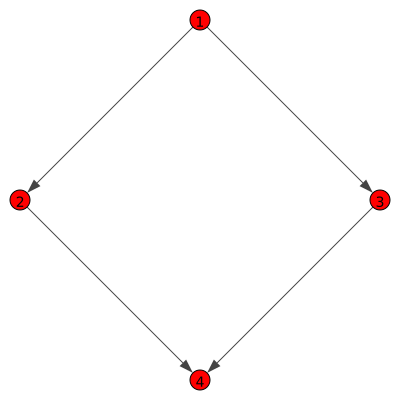

In [38]:
plot_map_graph(map_graph)

### III.3 Some examples with simple response patterns

So this response pattern should decrease the likelihood of mastering 2 and 4, but left the others unchanged.

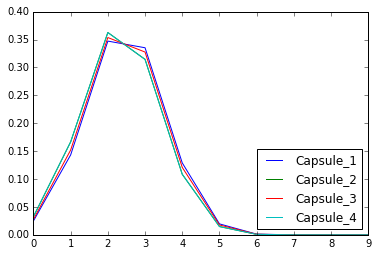

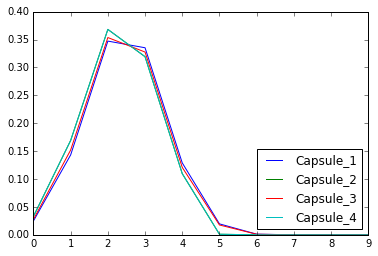

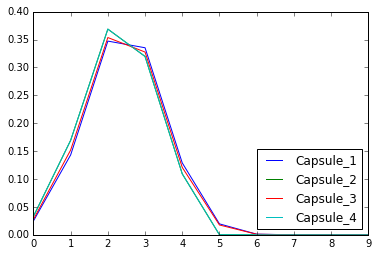

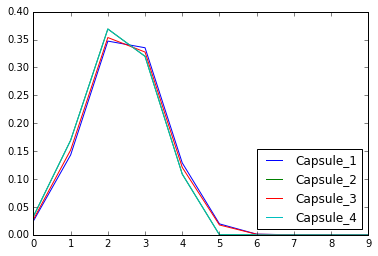

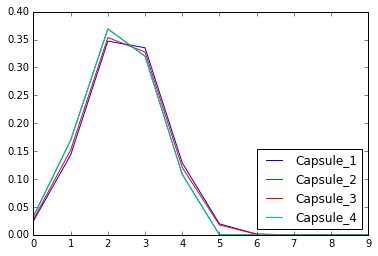

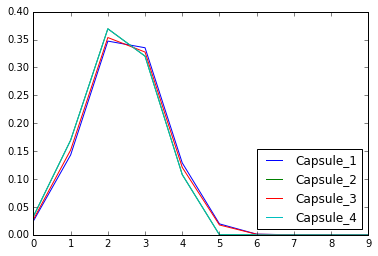

In [39]:
p_theta_updated = np.copy(p_theta_all)
for i in range(N[1]):
    fig = plt.figure()
    for j in range(len(N)):
        plt.plot(p_theta_updated[j])
        plt.legend(['Capsule_'+str(k+1) for k in range(len(N))], loc='lower right')
    p_theta_updated = update_proba(map_graph, p_theta_updated, proba_updaters, "q_2_"+str(i+1), 0)


Bingo !! Now our user will answer correctly every question of capsule 1, impacting every capsules :

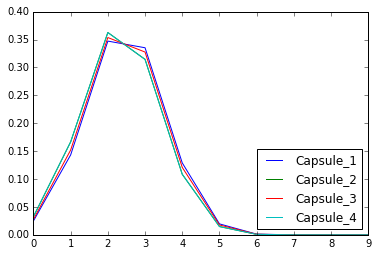

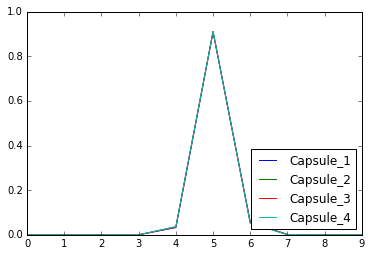

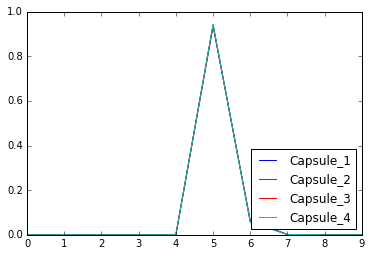

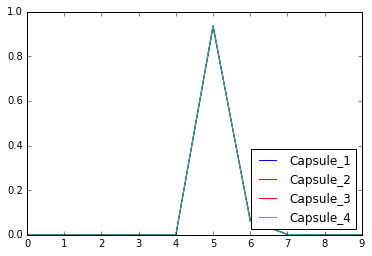

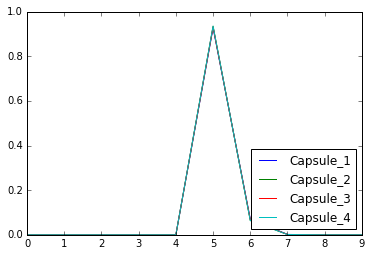

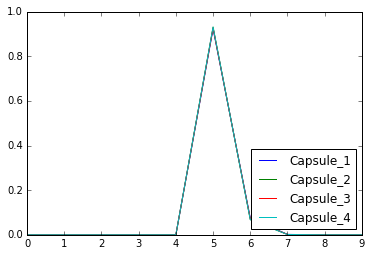

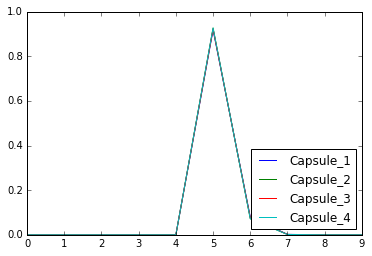

In [40]:
p_theta_updated = np.copy(p_theta_all)
for i in range(N[0]):
    fig = plt.figure()
    for j in range(len(N)):
        plt.plot(p_theta_updated[j])
        plt.legend(['Capsule_'+str(k+1) for k in range(len(N))], loc='lower right')
    p_theta_updated = update_proba(map_graph, p_theta_updated, proba_updaters, "q_1_"+str(i+1), 1)


Now the there is an user answering to capsule 4 randomly :


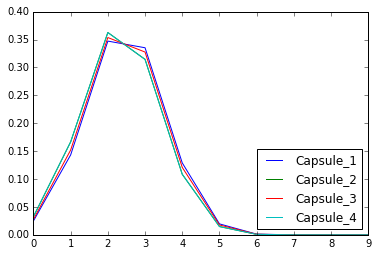

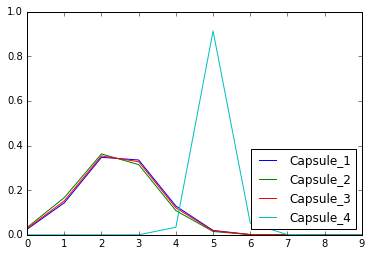

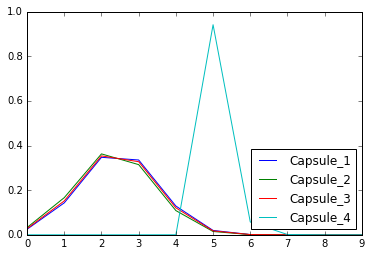

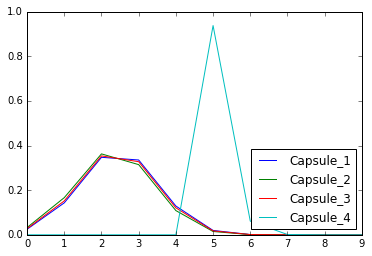

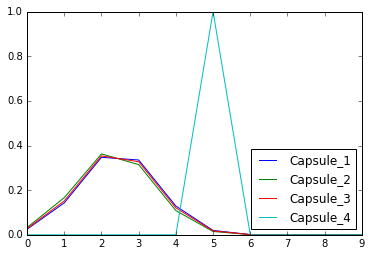

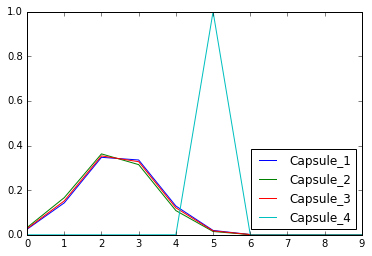

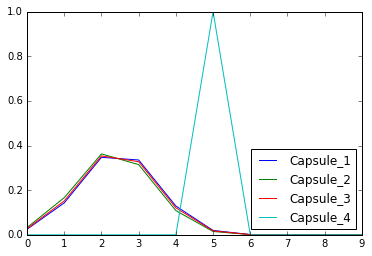

In [41]:
p_theta_updated = np.copy(p_theta_all)
for i in range(N[0]):
    fig = plt.figure()
    for j in range(len(N)):
        plt.plot(p_theta_updated[j])
        plt.legend(['Capsule_'+str(k+1) for k in range(len(N))], loc='lower right')
    p_theta_updated = update_proba(map_graph, p_theta_updated, proba_updaters, "q_4_"+str(i+1), np.random.binomial(p=0.5,n=1))


### III.4 Simulation with a simple map

In [42]:
# Let's do a quick simulation 

user_answers = np.array([[1,0,1,1,0,1,1],[0,1,0,0,1,1],[1,1,0,0,0],[0,0,0,0,0,1,1]])
list_to_mask = np.array([[0,0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0,0,0]])
for e in user_answers:
    print np.mean(e)


0.714285714286
0.5
0.4
0.285714285714


(3, 0)


/home/enguerand/.virtualenvs/gryzz-lab/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(2, 0)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, 1)
(2, 2)
(1, 4)
(1, 5)
(2, 3)
(2, 4)
(0, 0)
(0, 1)
(0, 2)
(0, 3)


/home/enguerand/.virtualenvs/gryzz-lab/local/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(0, 4)
(0, 5)
(0, 6)


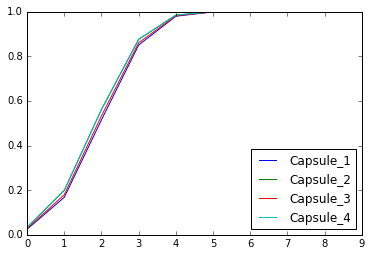

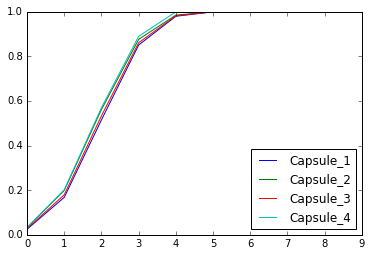

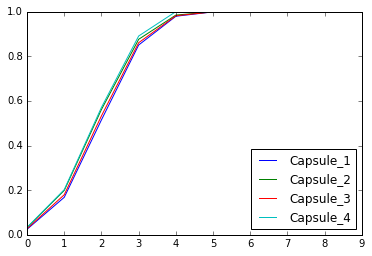

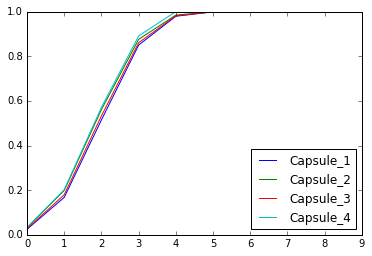

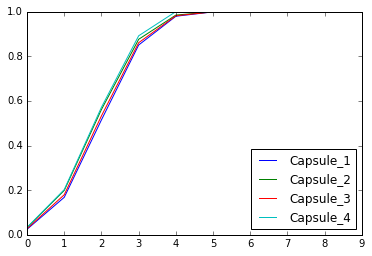

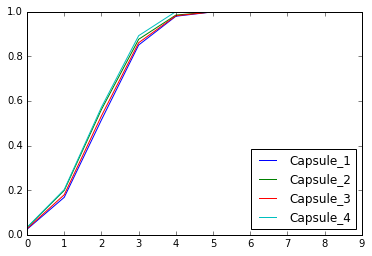

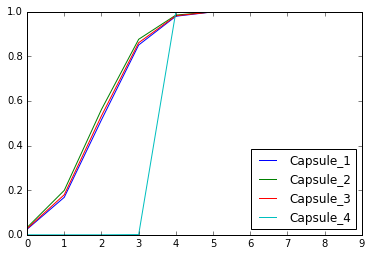

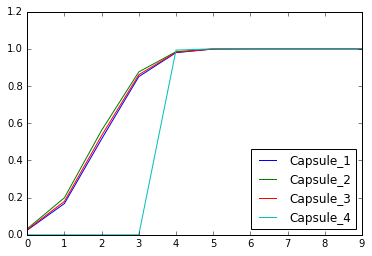

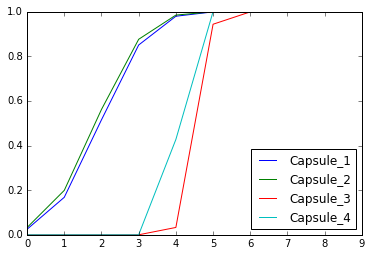

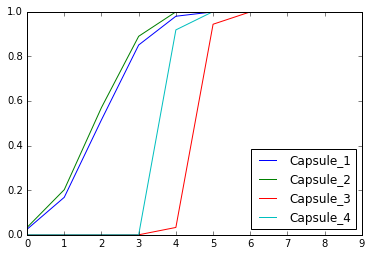

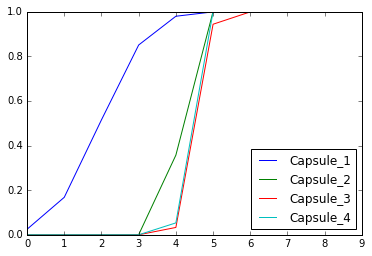

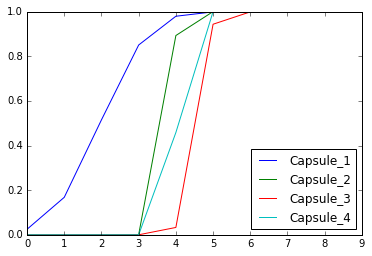

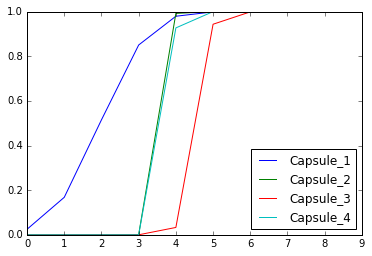

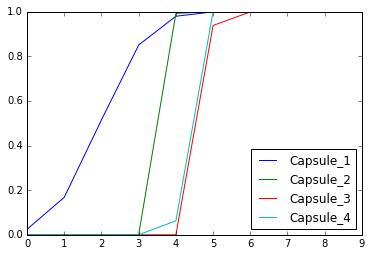

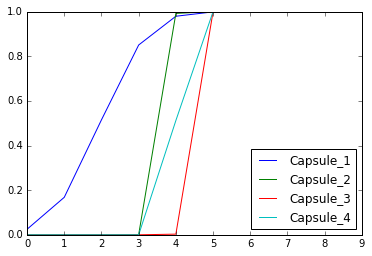

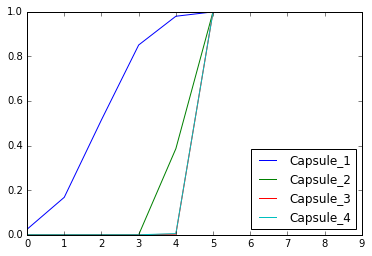

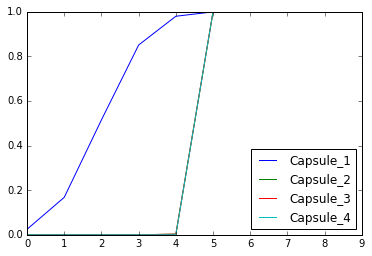

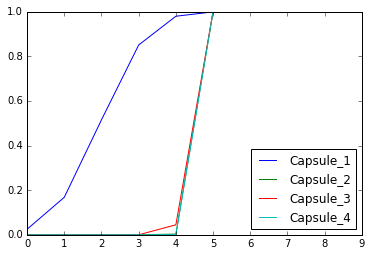

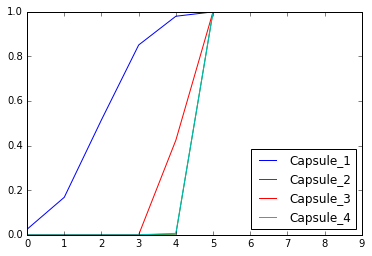

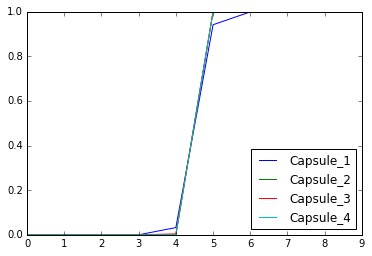

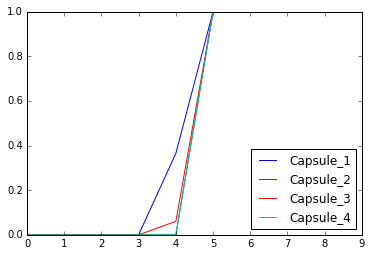

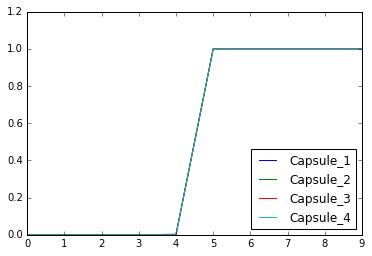

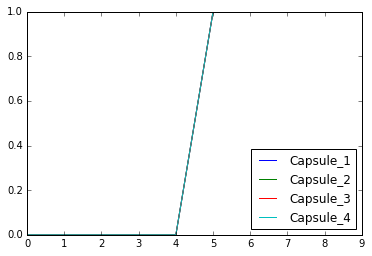

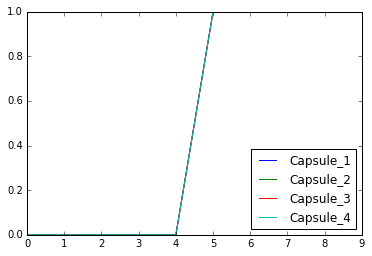

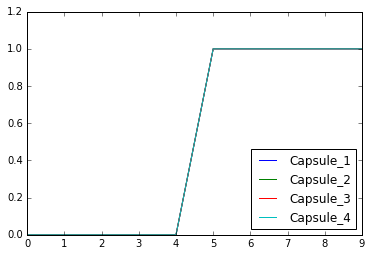

In [43]:
q_i_j = find_next_question(map_graph,p_theta_all,proba_updaters,N,list_to_mask)
p_theta_up = np.copy(p_theta_all)
warmup = 0
while (not(stopping_criterion_map(p_theta_up,delta=.6,criterion="custom")) or warmup < 5) and (not(np.all([np.all(a) for a in list_to_mask]))):
    print q_i_j
    fig = plt.figure()
    for j in range(len(N)):
        plt.plot(np.arange(10),np.array([sum(p_theta_up[j][:l+1]) for l in range(10)]))
        plt.legend(['Capsule_'+str(m+1) for m in range(len(N))], loc='lower right')
    i = q_i_j[0]
    j = q_i_j[1]
    p_theta_up = update_proba(
            map_graph,
            p_theta_up,
            proba_updaters,
            "q_"+str(i+1)+"_"+str(j+1),
            user_answers[i][j]
        )
    list_to_mask[i][j] = 1
    warmup +=1
    q_i_j = find_next_question(map_graph,p_theta_up,proba_updaters,N,list_to_mask)


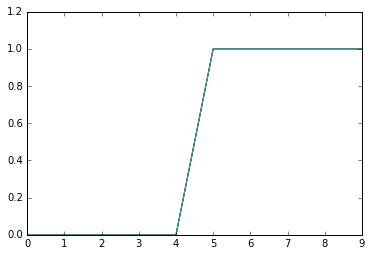

In [44]:
for j in range(len(N)):
    plt.plot(np.arange(10),np.array([sum(p_theta_up[j][:l+1]) for l in range(10)]))

In [45]:
for l in range(len(N)):
    print 1-np.sum(p_theta_up[l][:-3])

1.11022302463e-16
-2.22044604925e-16
1.11022302463e-16
1.11022302463e-16


In [46]:
"Out of %d questions, %d questions were asked" % (sum(N),sum(sum(list_to_mask)))

'Out of 25 questions, 25 questions were asked'

In [47]:
sum(p_theta_up[0])

1.0

In [48]:
for i in range(len(p_theta_up)):
    print "There are %d percent chance that capsule %d is not mastered" % (int(100*sum(p_theta_up[i][:5])),(i+1))
    print "There are %d percent chance that capsule %d is really mastered" % (int(100*(1-np.sum(p_theta_up[i][-3:]))),(i+1))

There are 0 percent chance that capsule 1 is not mastered
There are 100 percent chance that capsule 1 is really mastered
There are 0 percent chance that capsule 2 is not mastered
There are 100 percent chance that capsule 2 is really mastered
There are 0 percent chance that capsule 3 is not mastered
There are 100 percent chance that capsule 3 is really mastered
There are 0 percent chance that capsule 4 is not mastered
There are 100 percent chance that capsule 4 is really mastered


### III.5 Simulation with a bigger map


In [49]:
edges_list = [
    (0, 2),
    (0, 3),
    (0, 4),
    (0, 5),
    (5, 8),
    (1, 8),
    (2, 6),
    (3, 6),
    (3, 7),
    (4, 7),
    (6, 10),
    (8, 9),
    (9, 10)
]
N = [7, 6, 5, 7, 8, 9, 8, 7, 6, 5, 9] # Number of questions in each capsule

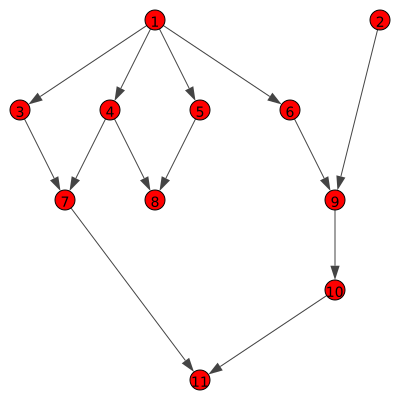

In [50]:
map_graph = create_map_graph(edges_list,N)
plot_map_graph(map_graph)

In [51]:
k = 10
number_users = 2000
number_questions = N
h =  .8
answers = []
scores = []
level_users = []
for i in range(len(N)):
    answer, score, level_user = generate_alt_score_panel(number_users, number_questions[i], k)
    answers.append(answer)
    scores.append(score)
    level_users.append(level_user)

In [52]:
proba_updaters = []
scores_updated = []
for i in range(len(N)):
    consistent_probas, updated_scores = find_consistent_probas(scores[i], answers[i], k, h)
    proba_updaters.append(consistent_probas)
    scores_updated.append(updated_scores)

In [53]:
p_theta_all = []
for i in range(len(N)):
    p_theta_all.append(p_theta(k))

In [54]:
proba_ans = [0.8,0.8,0.6,0.6,0.6,0.6,0.4,0.4,0.4,0.2,0.1]
user_answers = np.array([np.random.binomial(p=proba_ans[i],n=1,size=N[i]) for i in range(len(N))])
list_to_mask = user_answers/100
probas_obs = []
for e in user_answers:
    probas_obs.append(np.mean(e))
probas_obs

[0.7142857142857143,
 0.83333333333333337,
 1.0,
 0.7142857142857143,
 0.625,
 0.55555555555555558,
 0.25,
 0.42857142857142855,
 0.0,
 0.20000000000000001,
 0.1111111111111111]

<font color='red'><font size=20>#TO DO I can't manage to have a convergent criterion for the following example, so currently it stops after 20 questions</font></font>

In [55]:
q_i_j = find_next_question(map_graph,p_theta_all,proba_updaters,N,list_to_mask)
#q_i_j = 0,0
p_theta_up = np.copy(p_theta_all)
count = 0
list_asked_questions = [q_i_j]
while (count < 70) and (count <5 or not(stopping_criterion_map(p_theta_up,delta=.7,eps=.05, criterion="custom"))):
    i = q_i_j[0]
    j = q_i_j[1]
    print i,j
    """    fig = plt.figure()
    for f in range(len(N)):
        plt.plot(np.arange(10),np.array([sum(p_theta_up[f][:l+1]) for l in range(10)]))
        plt.legend(['Capsule_'+str(k+1) for k in range(len(N))], loc=[1,0])"""
    p_theta_up = update_proba(
            map_graph,
            p_theta_up,
            proba_updaters,
            "q_"+str(i+1)+"_"+str(j+1),
            user_answers[i][j]
        )
    list_to_mask[i][j] = 1
    q_i_j = find_next_question(map_graph,p_theta_up,proba_updaters,N,list_to_mask)
    count +=1
    list_asked_questions.append(q_i_j)

0 0
10 0
7 0
10 1
10 2


/home/enguerand/.virtualenvs/gryzz-lab/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


10 3
10 4
10 5
7 1
7 2
7 3
7 4
7 5
7 6
10 6
10 7
10 8
4 0
9 0
6 0
6 1
6 2
4 1
9 1
9 2
9 3
9 4
6 3
6 4
4 2
4 3
4 4
6 5
6 6
6 7
4 5
4 6
4 7
1 0


In [56]:
find_next_question(map_graph,p_theta_up,proba_updaters,N,list_to_mask)

(8, 0)

In [57]:
list_to_mask

array([array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0]),
       array([0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0]),
       array([1, 1, 1, 1, 1, 1, 1, 1]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]),
       array([1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1]),
       array([0, 0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1]),
       array([1, 1, 1, 1, 1, 1, 1, 1, 1])], dtype=object)

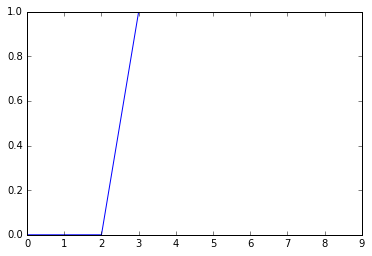

In [58]:
plt.plot(np.arange(10),np.array([sum(p_theta_up[10][:l+1]) for l in range(10)]))

In [59]:
for f in range(len(N)):
    print sum(p_theta_up[f][:6])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [60]:
for i in range(len(p_theta_up)):
    print "There are %d percent chance that capsule %d is really mastered %d" % (int(100*(1-sum(p_theta_up[i][:6]))),(i+1),int(100*probas_obs[i]))

There are 0 percent chance that capsule 1 is really mastered 71
There are 0 percent chance that capsule 2 is really mastered 83
There are 0 percent chance that capsule 3 is really mastered 100
There are 0 percent chance that capsule 4 is really mastered 71
There are 0 percent chance that capsule 5 is really mastered 62
There are 0 percent chance that capsule 6 is really mastered 55
There are 0 percent chance that capsule 7 is really mastered 25
There are 0 percent chance that capsule 8 is really mastered 42
There are 0 percent chance that capsule 9 is really mastered 0
There are 0 percent chance that capsule 10 is really mastered 20
There are 0 percent chance that capsule 11 is really mastered 11


In [61]:
sum_res = 0
for i in range(len(p_theta_up)):
    sum_res += ((int(100*(1-sum(p_theta_up[i][:6]))) >=50) == (int(100*probas_obs[i]) >= 50))
sum_res/10.

0.5

## Testing another item selection criterion

We have a model that works well with small maps but is way less effective with 

# A way to generate good simulated students 

In [39]:
def create_map_graph(edges_list,N=None):
    #rajouter un cas edge_list vide
    map_graph = Graph(edges_list, directed=True)
    map_graph.vs["label"] = map_graph.vs["name"] = [str(i+1) for i, v in enumerate(map_graph.vs)]
    if N is not None:
        map_graph.vs["item pool"] = [["q_"+str(i+1)+"_"+str(j+1) for j in range(N[i])] for i, v in enumerate(map_graph.vs)]
    return map_graph

def plot_map_graph(map_graph):
    layout = map_graph.layout_sugiyama()
    return igraph_plot(map_graph, bbox=(400, 400), layout=layout)

In [63]:
create_map_graph([])

In [171]:
#Example
edges_list = [
    (0, 1),
    (0, 2),
    (1,3),
    (2,3)
]
N = [10, 10, 10,10] 

In [65]:
edges_list = [
    (0, 1),
    (0, 2),
    (0, 3),
    (0, 4),
    (4, 7),
    (1, 5),
    (2, 5),
    (2, 6),
    (3, 6),
    (5, 9),
    (7, 8),
    (8, 9)
]
N = [7, 5, 7, 8, 9, 8, 7, 6, 5, 9] # Number of questions in each capsule

In [66]:
edges_list = [
    (0, 1),
    (0, 2),
    (0, 3),
    (3, 6),
    (2, 4),
    (2, 5),
]
#N = [7, 5, 7, 9, 8, 7, 6] # Number of questions in each capsule
N = [15]*7


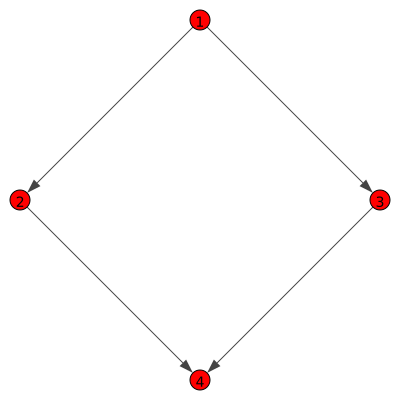

In [172]:

map_graph = create_map_graph(edges_list,N)
plot_map_graph(map_graph)

In [40]:
def proba_with_level(u,k):
    c = .5
    return np.where(u<(k/2.),(u*2.*c)/float(k),(3.*u+2*k-7.)/(5*(k-2.)))

In [41]:
@jit
def displaced_discrete_gaussian(level_max, factor=0):
    p_theta = np.arange(level_max)
    mean = (k/2.)+factor
    custom_norm = norm(loc=mean,scale=2.) 
    p_theta=custom_norm.cdf(p_theta)
    y = np.zeros(level_max)
    y[1:] = p_theta[:-1]
    p_theta = p_theta - y
    return p_theta/sum(p_theta)

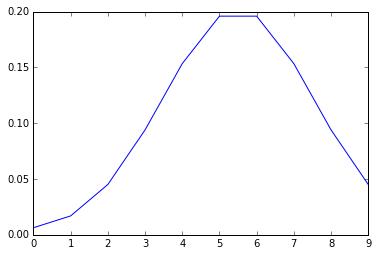

In [168]:
plt.plot(displaced_discrete_gaussian(10))

In [42]:
def generate_score_panel_with_hierarchy(k,map_graph,N, number_users):
    level_users = np.zeros([number_users, len(N)])
    answers = {}
    scores = {}
    visited_nodes = set()
    vals = np.arange(k)
    #probas = proba_with_level(vals,k)
    probas = proba_irt(1,5,0,vals)
    unvisited_nodes = set(map_graph.vs)
    mastered = np.zeros([number_users])
    while unvisited_nodes:
        for v in set(unvisited_nodes):
            capsule_pos = int(v["name"]) -1
            answers[capsule_pos] = np.zeros([number_users,N[capsule_pos]])
            parents = set(map_graph.vs[i] for i in map_graph.neighbors(v, mode="IN"))
            if parents:
                if parents <= visited_nodes:
                    v["depth"] = np.amax([parent["depth"] for parent in parents]) + 1
                    for user in range(number_users):
                        mastered_previous = any([level_users[user][int(parent["name"])-1] >= 5 for parent in parents])
                        if mastered_previous:
                            offset = v["depth"]/2.
                        else:
                            offset = 0
                        level_users[user][capsule_pos] = np.random.choice(
                            np.arange(k), p=displaced_discrete_gaussian(k,offset))
                        answers[capsule_pos][user] = (
                            np.random.binomial(
                                p=probas[level_users[user][capsule_pos]], n=1, size=N[capsule_pos]))
                    scores[capsule_pos] = np.mean(answers[capsule_pos],axis=1)
                    visited_nodes.add(v)
                    unvisited_nodes.remove(v)
            else:
                v["depth"] = 1
                for user in range(number_users):
                    level_users[user][0] = np.random.choice(np.arange(k), p=displaced_discrete_gaussian(k))
                    answers[capsule_pos][user] = (
                            np.random.binomial(
                                p=probas[level_users[user][capsule_pos]], n=1, size=N[capsule_pos]))
                scores[capsule_pos] = np.mean(answers[capsule_pos],axis=1)
                visited_nodes.add(v)
                unvisited_nodes.remove(v)
    return answers,scores,level_users

        

In [173]:
k = 10
number_users = 1000
answers, scores, level_users = generate_score_panel_with_hierarchy(k,map_graph,N, number_users)

/home/enguerand/.virtualenvs/gryzz-lab/lib/python2.7/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/enguerand/.virtualenvs/gryzz-lab/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [174]:
proba_updaters = []
scores_updated = []
h =1.
for i in range(len(N)):
    consistent_probas, updated_scores = find_consistent_probas(scores[i], answers[i], k, h)
    proba_updaters.append(consistent_probas)
    scores_updated.append(updated_scores)

0.359215171745


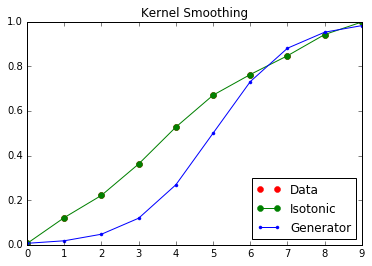

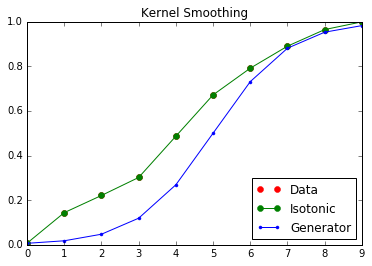

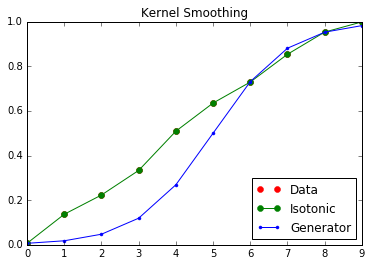

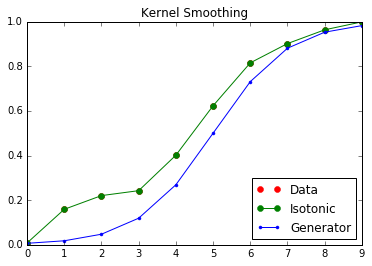

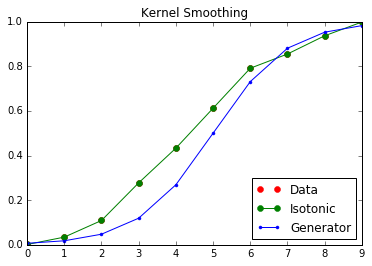

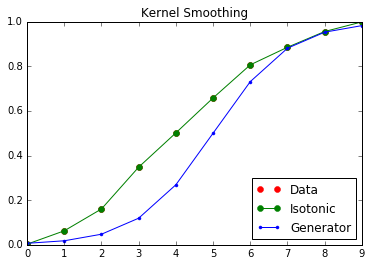

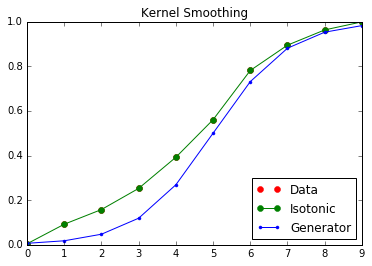

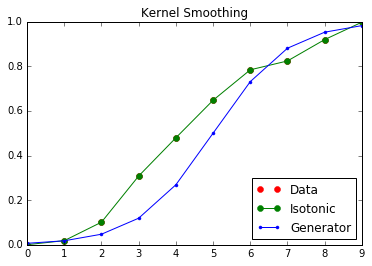

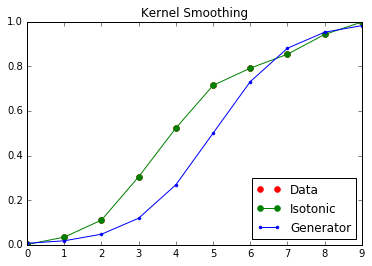

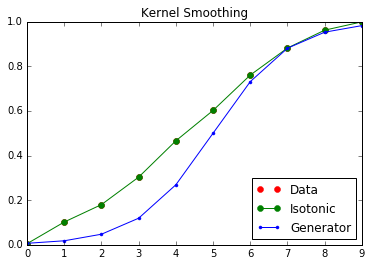

In [175]:

consistent_probas, updated_scores = proba_updaters[1], updated_scores[1]
number_questions = N[1]
x = np.zeros((number_questions,k))
y = np.zeros((number_questions,k))
y_ = np.zeros((number_questions,k))
for i in range(number_questions):
    x[i] = proba_irt(1,5,0,np.arange(k))
    y[i] = consistent_probas[i]

    # Fit IsotonicRegression in case the estimated probability is not increasing

    ir = IsotonicRegression(increasing=True)

    y_[i] = ir.fit_transform(np.arange(k), y[i])
    
#This is the mean square error which allows us to measure the accuracy of our estimation
mse = 0
for i in range(number_questions):
    mse += (1./len(y_[i]))*np.sum((y_[i]-x[i])**2)
print sqrt(mse)

# We hid everything that concerns Isotonic Regression, we will only need it if some curves are non-increasing
for i in range(number_questions):
    #segments = [[[o, y[i][o]], [o, y_[i][o]]] for o in range(k)]
    #lc = LineCollection(segments, zorder=0)
    #lc.set_array(np.ones(len(y[i])))
    #lc.set_linewidths(0.5 * np.ones(k))

    fig = plt.figure()
    plt.plot(np.arange(k), y[i], 'r.', markersize=12)
    plt.plot(np.arange(k), y_[i], 'g.-', markersize=12)
    plt.plot(np.arange(k), x[i],'b.-')
    #plt.gca().add_collection(lc)
    plt.legend(('Data', 'Isotonic', 'Generator'), loc='lower right')
    plt.title('Kernel Smoothing')

In [176]:
p_theta_all = []
for i in range(len(N)):
    p_theta_all.append(p_theta(k))

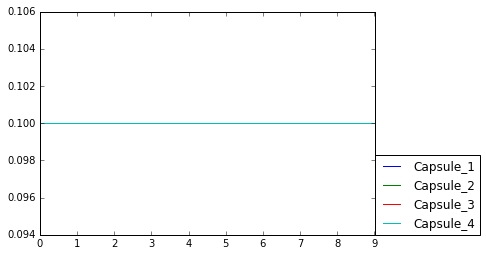

In [177]:
#An example of how our discretized distributions look
for i in range(len(p_theta_all)):
    plt.plot(p_theta_all[i])
    plt.legend(['Capsule_'+str(w+1) for w in range(len(N))], loc=[1,0])

In [178]:
# Let's do a quick simulation 
number_test_user = 50
user_test_answers, user_test_scores,level_test_user = generate_score_panel_with_hierarchy(k,map_graph,N,number_users=number_test_user)




/home/enguerand/.virtualenvs/gryzz-lab/lib/python2.7/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/enguerand/.virtualenvs/gryzz-lab/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [179]:
mean_accuracy = []
final_probas = []
for user in range(number_test_user):
    warmup = 30
    count = 1
    list_to_mask = [(l[0]/100).astype("int") for l in user_test_answers.values()]
    q_i_j = find_next_question(map_graph,p_theta_all,proba_updaters,N,list_to_mask)
    p_theta_up = np.copy(p_theta_all)
    while (count < warmup):
        #fig = plt.figure()
        #for j in range(len(N)):
            #plt.plot(np.arange(10),p_theta_up[j])
            #plt.legend(['Capsule_'+str(m+1) for m in range(len(N))], loc='lower right')
        i = q_i_j[0]
        j = q_i_j[1]
        #print level_test_user[0][i]
        p_theta_up = update_proba(
                map_graph,
                p_theta_up,
                proba_updaters,
                "q_"+str(i+1)+"_"+str(j+1),
                user_test_answers[i][user][j]
            )
        list_to_mask[i][j] = 1
        count +=1
        q_i_j = find_next_question(map_graph,p_theta_up,proba_updaters,N,list_to_mask)
    if user % 10 == 0:
        print user
    final_probas.append(p_theta_up)
    accuracy = []
    for index,p in enumerate(final_probas):
        sum_res = 0
        for i in range(len(N)):
            sum_res += ((int(100*(1-sum(p[i][:5]))) >50) == (level_test_user[index][i] >= 5))
        accuracy.append(sum_res/float(len(N)))
    mean_accuracy.append(np.mean(np.array(accuracy)))

0
10
20
30
40


In [79]:
accuracy = []
for index,p in enumerate(final_probas):
    sum_res = 0
    for i in range(len(N)):
        sum_res += ((int(100*(1-sum(p[i][:5]))) >50) == (level_test_user[index][i] >= 5))
    accuracy.append(sum_res/float(len(N)))
np.mean(np.array(accuracy))

0.77714285714285714

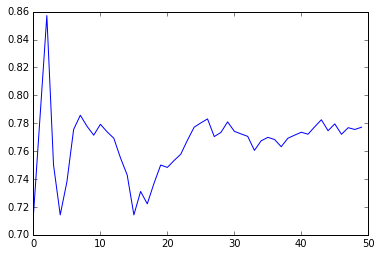

In [80]:
plt.plot(mean_accuracy)

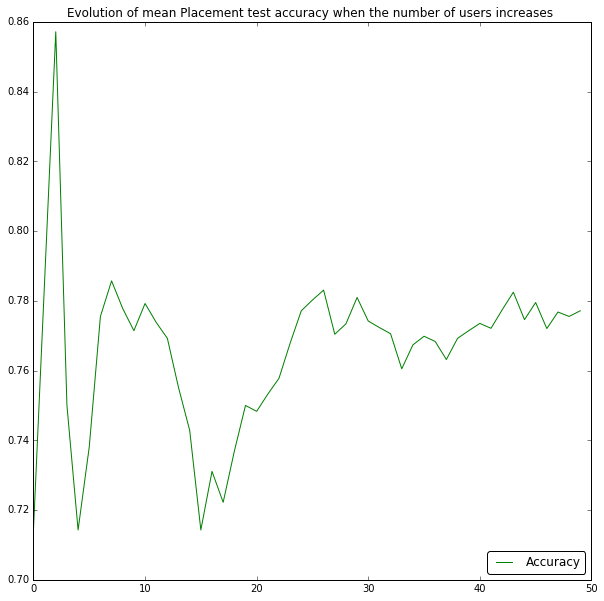

In [81]:
fig = plt.figure(figsize=[10,10])
testest = plt.plot(mean_accuracy,'-g', markersize=12)
plt.legend(['Accuracy'], loc = "lower right", fancybox=True)
plt.title("Evolution of mean Placement test accuracy when the number of users increases ")
#plt.savefig("Mean accuracy small map")

In [180]:
warmup = 40

accuracy = [[] for g in range(number_test_user)]
for user in range(number_test_user):
    count = 0
    list_to_mask = [(l[0]/100).astype("int") for l in user_test_answers.values()]
    q_i_j = find_next_question(map_graph,p_theta_all,proba_updaters,N,list_to_mask)
    p_theta_up = np.copy(p_theta_all)

    while (count < warmup):
        #fig = plt.figure()
        #for j in range(len(N)):
            #plt.plot(np.arange(10),p_theta_up[j])
            #plt.legend(['Capsule_'+str(m+1) for m in range(len(N))], loc='lower right')
        i = q_i_j[0]
        j = q_i_j[1]
        #print level_test_user[0][i]
        p_theta_up = update_proba(
                map_graph,
                p_theta_up,
                proba_updaters,
                "q_"+str(i+1)+"_"+str(j+1),
                user_test_answers[i][user][j]
            )
        list_to_mask[i][j] = 1
        count +=1
        q_i_j = find_next_question(map_graph,p_theta_up,proba_updaters,N,list_to_mask)
        sum_res = 0
        for l in range(len(N)):
            sum_res += ((1-sum(p_theta_up[l][:5])) >.7) == (level_test_user[user][l] >= 7)
            #sum_res +=( np.argmax(p_theta_up[l]) == level_test_user[index][l]) or ( np.argmax(p_theta_up[l])-1 == level_test_user[index][l]) or ( np.argmax(p_theta_up[l])+1 == level_test_user[index][l])
        accuracy[user].append(sum_res/float(len(N)))
        
        
    if user % 10 == 0:
        print user
    final_probas.append(p_theta_up)

0
10
20
30
40


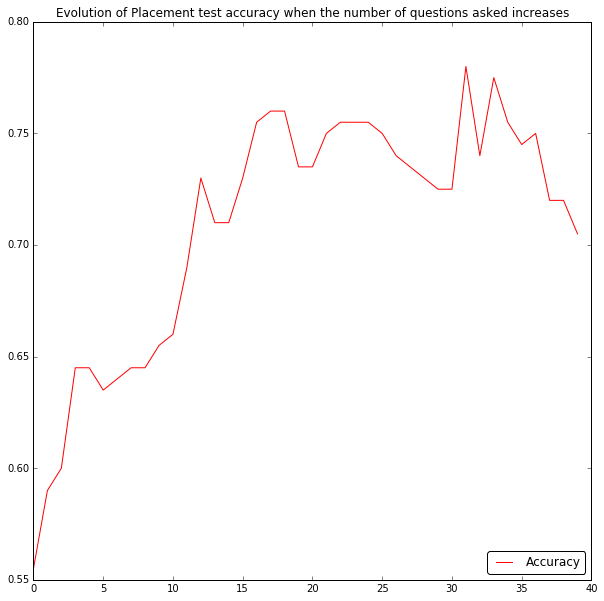

In [181]:
fig = plt.figure(figsize=[10,10])
testest = plt.plot(np.mean(accuracy, axis=0),'-r', markersize=12)
plt.legend(['Accuracy'], loc = "lower right", fancybox=True)
plt.title("Evolution of Placement test accuracy when the number of questions asked increases")
#plt.savefig("Successful accuracy for small map")

In [183]:
np.mean(accuracy,axis=0)

array([ 0.555,  0.59 ,  0.6  ,  0.645,  0.645,  0.635,  0.64 ,  0.645,
        0.645,  0.655,  0.66 ,  0.69 ,  0.73 ,  0.71 ,  0.71 ,  0.73 ,
        0.755,  0.76 ,  0.76 ,  0.735,  0.735,  0.75 ,  0.755,  0.755,
        0.755,  0.75 ,  0.74 ,  0.735,  0.73 ,  0.725,  0.725,  0.78 ,
        0.74 ,  0.775,  0.755,  0.745,  0.75 ,  0.72 ,  0.72 ,  0.705])

In [ ]:
np.argmax(p_theta_up,axis=1)

In [116]:
class PlacementTest:
    
    def __init__(self, answers, train_test=False):
        scores = {}
        N = []
        if train_test:
            scores_test = {}
            answers_test = {}
        for key, answer in answers.iteritems():
            scores[key] = np.mean(answer, axis = 1)
            N.append(len(answer[0]))
        self.scores = scores
        self.answers = answers
        self.N = N
    
    def train_model(self, h=.8):
        proba_updaters = []
        scores_updated = []
        for i in range(len(self.N)):
            consistent_probas, updated_scores = find_consistent_probas(self.scores[i], self.answers[i], k, h)
            proba_updaters.append(consistent_probas)
            scores_updated.append(updated_scores)
        self.proba_updaters = proba_updaters
        self.scores_updated = scores_updated
    
    def isotonic_smoothing(self):
        for i in range(len(test.N)):
            consistent_probas, updated_scores = self.proba_updaters[i], self.scores_updated[i]
            number_questions = self.N[i]
            x = np.zeros((number_questions,k))
            y = np.zeros((number_questions,k))
            y_ = np.zeros((number_questions,k))
            for j in range(number_questions):
                x[j] = proba_irt(1,5,0,np.arange(k))
                y[j] = consistent_probas[j]

            # Fit IsotonicRegression in case the estimated probability is not increasing

                ir = IsotonicRegression(increasing=True)

                y_[j] = ir.fit_transform(np.arange(k), y[j])
            self.proba_updaters[i] = y_
    
    def split_train_test(self):
             pass

In [176]:

import pickle

pkl_file = open('list_answers_final_num_train.pkl', 'rb')

list_answers_train = pickle.load(pkl_file)
pkl_file.close()
pkl_file = open('list_answers_final_num_test.pkl', 'rb')

list_answers_test = pickle.load(pkl_file)
pkl_file.close()

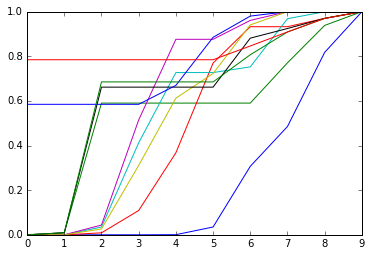

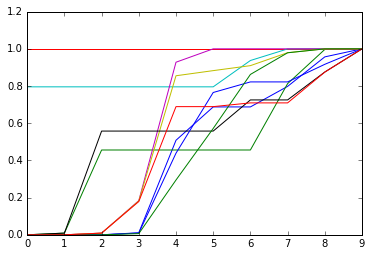

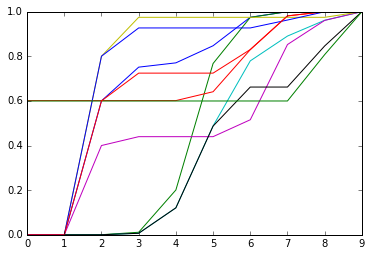

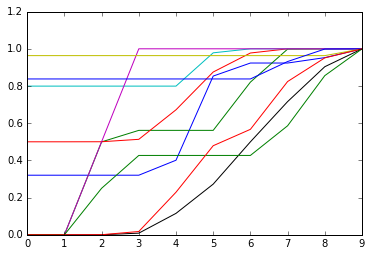

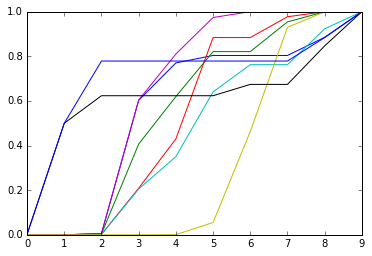

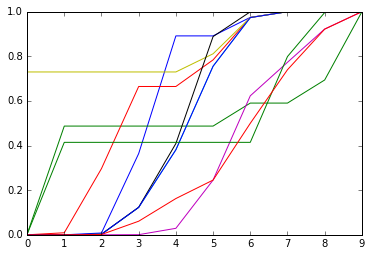

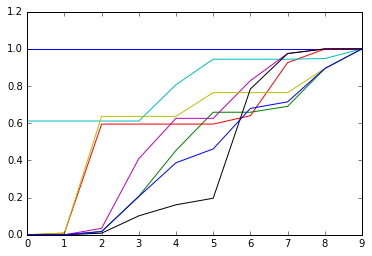

In [177]:
train = PlacementTest(list_answers_train)
test = PlacementTest(list_answers_test)
train.train_model(.8)
train.isotonic_smoothing()
for i in range(len(train.proba_updaters)):
    fig = plt.figure()
    for j in range(len(train.proba_updaters[i])):
        plt.plot(train.proba_updaters[i][j])

In [119]:
edges_list = [
    (0, 1),
    (1, 2),
    (2, 3),
    (2, 4),
    (3, 5),
    (4, 5),
    (5, 6)
]



In [148]:
print ([len(train.scores[i]) for i in range(len(train.scores))])
print ([len(test.scores[i]) for i in range(len(test.scores))])

[56, 45, 42, 39, 43, 34, 38]
[10, 10, 10, 10, 10, 10, 10]


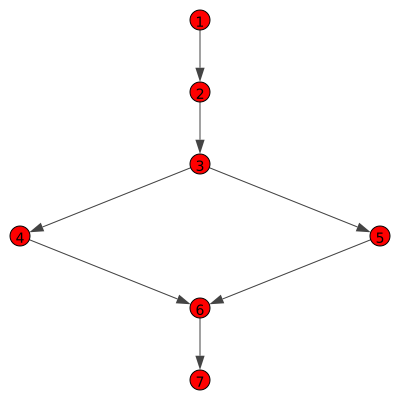

In [121]:

map_graph = create_map_graph(edges_list,test.N)
plot_map_graph(map_graph)

In [122]:
p_theta_all = []
for i in range(len(test.N)):
    p_theta_all.append(p_theta(k))

In [130]:
len

[array([[  7.44672046e-25,   1.02564612e-16,   1.25568315e-10,
           7.55734831e-07,   5.28280376e-04,   3.49372920e-02,
           3.06717628e-01,   4.85057586e-01,   8.17370381e-01,
           9.99448901e-01],
        [  7.81176107e-07,   9.13285438e-03,   5.90090039e-01,
           5.90090039e-01,   5.90090039e-01,   5.90090039e-01,
           5.90090039e-01,   7.70399264e-01,   9.38101686e-01,
           9.99816164e-01],
        [  1.38880198e-11,   3.69310211e-06,   8.75536424e-03,
           1.08862971e-01,   3.67413669e-01,   7.69495768e-01,
           9.32343833e-01,   9.32343833e-01,   9.69747436e-01,
           9.99908175e-01],
        [  5.55518080e-11,   1.47707672e-05,   3.49331711e-02,
           4.12099968e-01,   7.26890112e-01,   7.26890112e-01,
           7.52308099e-01,   9.68086022e-01,   9.99442433e-01,
           9.99999926e-01],
        [  6.94397519e-11,   1.84634097e-05,   4.36638154e-02,
           5.14425007e-01,   8.75855222e-01,   8.75855222e-01,
      

In [164]:
final_probas = []
number_test_users = min([len(test.scores[i]) for i in range(len(test.scores))])
accuracy = [[] for g in range(number_test_users)]
list_question_asked = []
for user in range(number_test_users):
    warmup = 66
    count = 1
    list_to_mask = [(l[0]/100).astype("int") for l in test.answers.values()]
    q_i_j = find_next_question(map_graph,p_theta_all,train.proba_updaters,test.N,list_to_mask)
    p_theta_up = np.copy(p_theta_all)
    list_question_asked.append([])
    while (count < warmup):
        list_question_asked[-1].append(q_i_j)
        i = q_i_j[0]
        j = q_i_j[1]
        #print level_test_user[0][i]
        p_theta_up = update_proba(
                map_graph,
                p_theta_up,
                train.proba_updaters,
                "q_"+str(i+1)+"_"+str(j+1),
                test.answers[i][user][j]
            )
        list_to_mask[i][j] = 1
        count +=1
        q_i_j = find_next_question(map_graph,p_theta_up,train.proba_updaters,test.N,list_to_mask)
        sum_res = 0
        for l in range(len(test.N)):
            sum_res += ((1-sum(p_theta_up[l][:5])) >.7) == (test.scores[l][user] > .7)
            #sum_res +=( int(np.argmax(p_theta_up[l])) == int(10*test.scores[l][user]))  or ( int(np.argmax(p_theta_up[l]))-1 == int(10*test.scores[l][user])) or ( int(np.argmax(p_theta_up[l]))+1 == int(10*test.scores[l][user])) or ( int(np.argmax(p_theta_up[l]))+2 == int(10*test.scores[l][user])) ( int(np.argmax(p_theta_up[l]))-2 == int(10*test.scores[l][user]))
        accuracy[user].append(sum_res/float(len(test.N)))

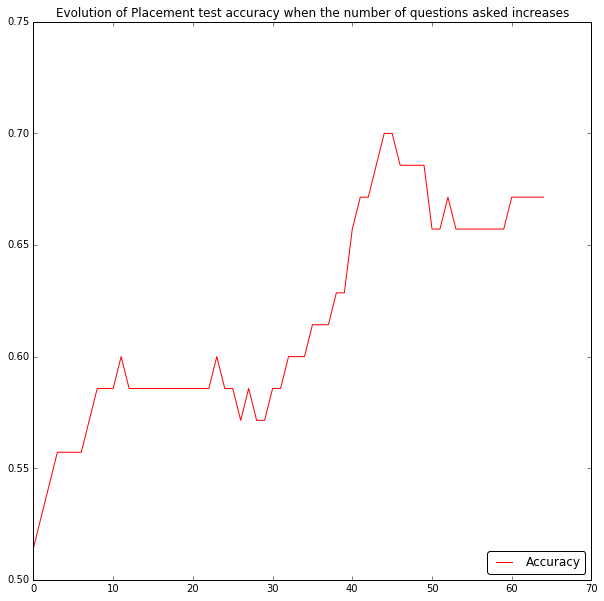

In [165]:
fig = plt.figure(figsize=[10,10])
testest = plt.plot(np.mean(accuracy, axis=0),'-r', markersize=12)
plt.legend(['Accuracy'], loc = "lower right", fancybox=True)
plt.title("Evolution of Placement test accuracy when the number of questions asked increases")
#plt.savefig("Successful accuracy for small map")

In [197]:
final_probas = []
number_test_users = min([len(test.scores[i]) for i in range(len(test.scores))])
accuracy = [[] for g in range(number_test_users)]
list_question_asked = []
for user in range(number_test_users):
    warmup = 66
    count = 1
    list_to_mask = [(l[0]/100).astype("int") for l in test.answers.values()]
    q_i_j = find_next_question(map_graph,p_theta_all,train.proba_updaters,test.N,list_to_mask)
    p_theta_up = np.copy(p_theta_all)
    list_question_asked.append([])
    while (count < warmup):
        list_question_asked[-1].append(q_i_j)
        i = q_i_j[0]
        j = q_i_j[1]
        #print level_test_user[0][i]
        p_theta_up = update_proba(
                map_graph,
                p_theta_up,
                train.proba_updaters,
                "q_"+str(i+1)+"_"+str(j+1),
                test.answers[i][user][j]
            )
        list_to_mask[i][j] = 1
        count +=1
        q_i_j = find_next_question(map_graph,p_theta_up,train.proba_updaters,test.N,list_to_mask)
        sum_res = 0
        for l in range(len(test.N)):
            sum_res += ((1-sum(p_theta_up[l][:5])) >.5) == (test.scores[l][user] > .7)
            #sum_res +=( int(np.argmax(p_theta_up[l])) == int(10*test.scores[l][user]))  or ( int(np.argmax(p_theta_up[l]))-1 == int(10*test.scores[l][user])) or ( int(np.argmax(p_theta_up[l]))+1 == int(10*test.scores[l][user])) or ( int(np.argmax(p_theta_up[l]))+2 == int(10*test.scores[l][user])) ( int(np.argmax(p_theta_up[l]))-2 == int(10*test.scores[l][user]))
        accuracy[user].append(sum_res/float(len(test.N)))
    for i in range(len(test.N)):
        list_answers_train[i]= concatenate([list_answers_train[i], [test.answers[i][user]]])
    train = PlacementTest(list_answers_train)
    train.train_model(.8)
    train.isotonic_smoothing()

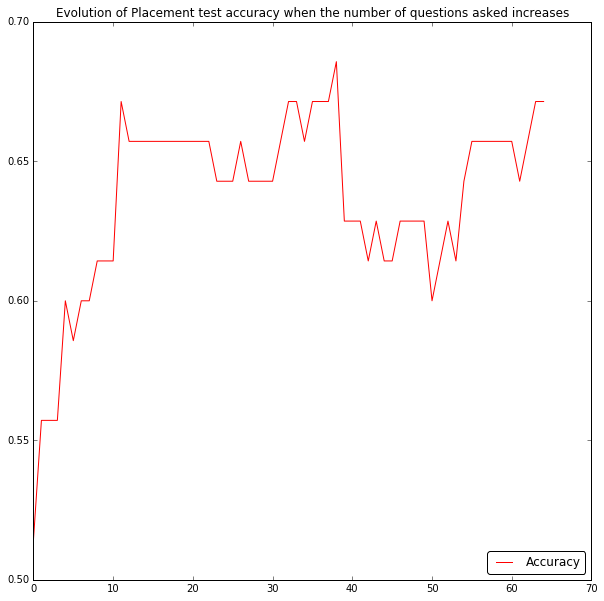

In [198]:
fig = plt.figure(figsize=[10,10])
testest = plt.plot(np.mean(accuracy, axis=0),'-r', markersize=12)
plt.legend(['Accuracy'], loc = "lower right", fancybox=True)
plt.title("Evolution of Placement test accuracy when the number of questions asked increases")
#plt.savefig("Successful accuracy for small map")